# Importação das bibliotecas necessárias

&nbsp;&nbsp;&nbsp;&nbsp;Essa seção é voltada justamente para fazer a primeira importação de quais são as bibliotecas que foram utilizadas para a construção do modelo preditivo. É importante ressaltar que é necessário tê-las instaladas no seu ambiente de desenvolvimento. Isso pode ser feito consultando a documentação para identificar o comando de instação de cada uma.

In [15]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# Carregamento dos dados

&nbsp;&nbsp;&nbsp;&nbsp;Primeiro, para o treinamento do modelo preditivo foi carregado o csv principal com os dados disponibilizados pela plataforma Kaggle. Também foi identificado se havia valores nulos no dataframe, o que resultou em uma resposta negativa, então não foi desenvolvida nenhuma ação para a tratativa de possíveis valores nulos.

In [16]:
# Carregamento dos dados de treino
df_train = pd.read_csv('train.csv')

# Verificando valores nulos
df_train.isnull().sum()

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64

# Codificação das variáveis categóricas

&nbsp;&nbsp;&nbsp;&nbsp;Para a codificação das variáveis categóricas, passo essencial para a construção do modelo, foram primeiro identificadas quais são as colunas que se relacionam a dados de origem categórica e, nesse processo, buscou-se aplicar nelas o algoritmo LabelEncoder() que é uma técnica simples e eficiente, da biblioteca scikit-learn, que mapeia cada categoria para um valor numérico único.

&nbsp;&nbsp;&nbsp;&nbsp;Foi desenvolvido um loop for para percorrer todos as colunas que eram categóricas do dataframe.

In [17]:
# identifica atributos que são categóricos
categorical_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# atribui o codificador LabelEncoder para uma variável
encoder = LabelEncoder()

# faz loop for para codificar cada uma das variáveis categóricas
for col in categorical_features:
    encoder = LabelEncoder()
    df_train[col] = encoder.fit_transform(df_train[col])


# Análise de correlação das variáveis codificadas

&nbsp;&nbsp;&nbsp;&nbsp;Pós-normalização, como forma de exploração de dados buscada para entender os dados do dataframe utilizado, fez-se uma análise de correlação entre as variáveis dispostas no dataframe. 

&nbsp;&nbsp;&nbsp;&nbsp;Além disso, como maneira de consolidar esse entendimento, desenvolveu-se um heatmap para visualizar, realmente, quão quentes ou frias estão essas variáveis em relação à popularidade.

In [18]:
# define variável para todas as features
all_features = df_train.columns

# tira a feature de popularidade para identificar a correção em relaç~~ao a ela
features = df_train.drop(columns=['popularity_target']).columns

# desenvolve a análise de correlações dos valores dos atributos
correlations = df_train[features].corrwith(df_train['popularity_target']).sort_values(ascending=False)

correlations

danceability        0.057848
track_genre         0.054439
track_unique_id     0.053868
loudness            0.048140
time_signature      0.036454
album_name          0.026430
explicit            0.016312
tempo               0.012839
track_id            0.004577
key                 0.004285
track_name          0.002299
artists             0.000685
duration_ms        -0.001405
liveness           -0.007691
acousticness       -0.009095
mode               -0.013869
energy             -0.025979
valence            -0.043138
speechiness        -0.091055
instrumentalness   -0.100967
dtype: float64

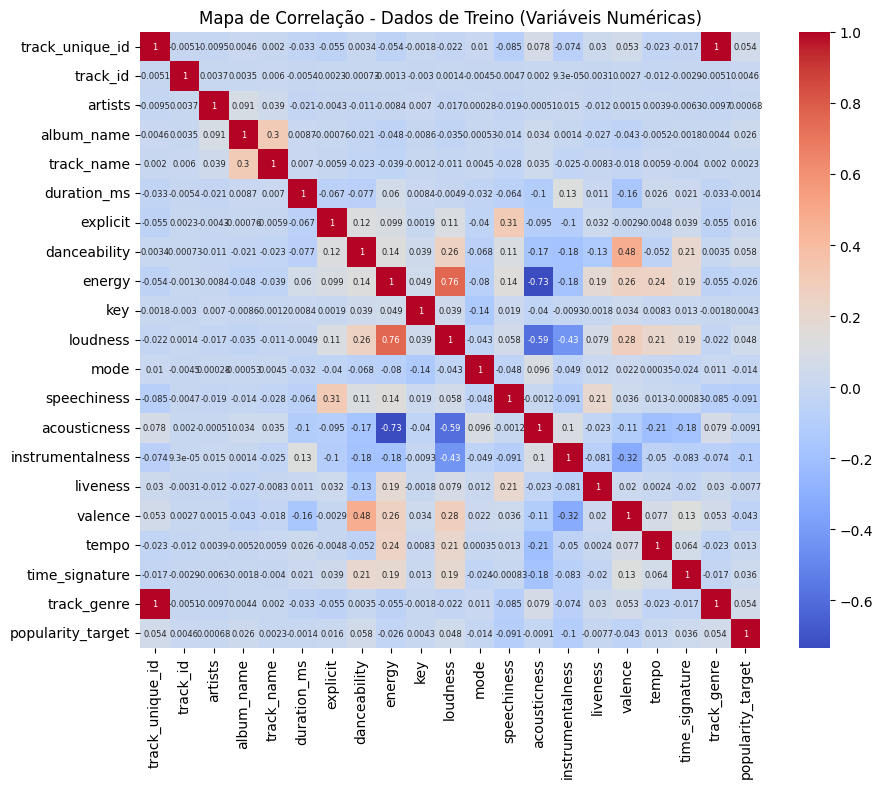

In [19]:
# plota heatmap com os dados de treino codificados
plt.figure(figsize=(10, 8))
sns.heatmap(df_train[all_features].corr(), annot=True, annot_kws={"size": 6}, cmap='coolwarm')
plt.title('Mapa de Correlação - Dados de Treino (Variáveis Numéricas)')
plt.show()

## Formulação de Hipóteses

&nbsp;&nbsp;&nbsp;&nbsp;A seção de formulação de hipóteses é destinada a identificar pontos principais de discursão com base na exploração de dados. Ela é fundamental para trazer como percepção proeminente como que de fato é possível construir essas pontes e identificar os cenários reais dos dados.

&nbsp;&nbsp;&nbsp;&nbsp;As hipóteses formuladas para o modelo preditivo se baseiam, principalmente, nas análises proporcionadas pela matriz de correlação disposta acima. Através dela, foi possível perceber que algumas variáveis são bastante relevantes no que se refere à análise do que é fundamental para o estabelecimento de uma alta popularidade de uma música. Ou seja das canções que, provavelmente, se tornariam o próximo hit do spotify.

&nbsp;&nbsp;&nbsp;&nbsp;Nesse sentido, a primeira hipótese que se coloca com bastante proeminência, é a questão da variável de danceability, quão propensa a música é em te fazer dançar, em relação à variável de popularidade. Faz-se bastante relevante, considerando que, nos tempos atuais, músicas são construídas, muitas vezes, com o intuito de viralizar em alguma rede social, como o TikTok, então esse critério faz sentido considerando o panorama hodierno.

&nbsp;&nbsp;&nbsp;&nbsp;Outro ponto que se destacou foi a questão de "valência", nas músicas, ou seja, o quão elas são consideradas músicas felizes. É um ponto que se fez notável porque se esperava que o quão maior fosse esse atributo, mais populares as músicas seriam, mas há um contraponto negativo. A variável, apesar de não destoar significativamente, se encontra com valor negativo em relação à popularidade. Ponto que foi interessante de analisar com base nos dados.

&nbsp;&nbsp;&nbsp;&nbsp;Por fim, outro ponto em caráter de associação negativa, foi o de instrumentabilidade, este que apresenta uma das mais expressivas distâncias em relação ao ponto de popularidade das músicas. Foi interessante perceber isso, porque trouxe à tona o critério de que realmente músicas que utilizam mais do recurso vocal hoje são mais interessantes ao público do que aquelas que fazem proeminente uso da instrumentabilidade e colocam vários períodos disso intercaladas na canção.

&nbsp;&nbsp;&nbsp;&nbsp;Essas três hipóteses levantadas com base na matriz de correlação identificam pontos-chave a serem considerados no desenvolvimento do modelo preditivo.


# Divisão dos dados em teste e treino

&nbsp;&nbsp;&nbsp;&nbsp;Para validação do modelo, ainda com os dados de treinamento, fez-se uma escolha de fazer o split com base no test_size de 0.2. É interessante, para conseguir identificar ainda mais quão generalista é o algoritmo utilizado pelo modelo.

&nbsp;&nbsp;&nbsp;&nbsp;Prezou-se por utilizar todas as variáveis para entender o comportamento do modelo com a análise de todas elas.

In [20]:
# identifica variável-alvo e variáveis para serem colocadas pelo modelo
X=df_train[features]
y=df_train['popularity_target']

# faz o split dos dados de teste e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hiperparametrização do modelo

&nbsp;&nbsp;&nbsp;&nbsp;Hiperparâmetros são configurações que não são aprendidas diretamente pelo modelo durante o processo de treinamento. Eles são definidos antes do processo de aprendizado e influenciam como o algoritmo de machine learning funciona. Exemplos de hiperparâmetros que foram utilizados para o fine tuning incluem a profundidade máxima de uma árvore de decisão, o número de estimadores em um modelo de floresta aleatória (RandomForest) e a função de critério usada para decidir a divisão dos nós.

&nbsp;&nbsp;&nbsp;&nbsp;A escolha correta dos hiperparâmetros pode ter um impacto significativo no desempenho do modelo. Portanto, a busca por esses parâmetros ideais é uma etapa importante no desenvolvimento de um modelo robusto.

&nbsp;&nbsp;&nbsp;&nbsp;A técnica de busca por hiperparâmetros utilizada neste caso é o RandomizedSearchCV. Essa técnica realiza uma busca aleatória por meio de um espaço de hiperparâmetros pré-definido, experimentando combinações aleatórias de valores. Em comparação ao GridSearchCV, o RandomizedSearchCV é mais eficiente em termos de tempo de computação, especialmente quando o espaço de busca é grande, já que ele não testa todas as combinações possíveis, mas sim uma amostra delas.

In [21]:
classifier = RandomForestClassifier()

# Definindo os parâmetros para busca
param_dist = {
    'n_jobs': [-1],
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, 20, 50, 100],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42],
}

# Configurando RandomizedSearchCV
random_search = RandomizedSearchCV(
    classifier,
    param_distributions=param_dist,
    n_iter=50,  # número de combinações aleatórias para experimentar
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Treinando o modelo com RandomizedSearchCV
random_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros
print('****************************************************************************************')
print(random_search.best_params_)

best_params = random_search.best_params_

KeyboardInterrupt: 

&nbsp;&nbsp;&nbsp;&nbsp;Com os melhores hiperparâmetros encontrados, um novo modelo de RandomForestClassifier é instanciado e treinado com esses valores ótimos. A seguir, o código utilizado para aplicar esses hiperparâmetros ao modelo final:

In [30]:
best_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'criterion': 'gini',
    'max_depth': 15,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42
}

# faz o melhor modelo com base nos melhores parâmetros identificados
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=best_params['random_state'],
    n_jobs=best_params['n_jobs']
)

# treina o modelo com os dados de treino
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

# avalia o modelo
accuracy_train = best_model.score(X_train, y_train)
accuracy_val = best_model.score(X_test, y_test)

# printa as acurácias obtidas no conjunto de treino e de validação
print(f"Acurácia no conjunto de treino: {accuracy_train:.4f}")
print(f"Acurácia no conjunto de validação: {accuracy_val:.4f}")

Acurácia no conjunto de treino: 0.9150
Acurácia no conjunto de validação: 0.8056


In [33]:
df_predictions = pd.DataFrame({
    'track_unique_id': X_test['track_unique_id'],  # Supondo que o track_id esteja em X_test
    'predicted_popularity': y_pred
})

# Passo 3: Salvar o DataFrame em um arquivo CSV
df_predictions.to_csv('submission.csv', index=False)

# Processamento do dataframe do teste

&nbsp;&nbsp;&nbsp;&nbsp;Para estabelecer as mesmas condições destinadas ao dataframe inicial, visou-se aplicar a encodificação das variáveis categóricas para deixá-las nos mesmos moldes dispostos para o conjunto de treino e validação inicial.

In [9]:
# carrega o dataframe de teste
test_df = pd.read_csv('test.csv')

# identifica atributos que são categóricos
categorical_atributes = test_df.select_dtypes(include=['object', 'category']).columns.tolist()

# laço for para codificar cada uma das colunas do atributo
for col in categorical_atributes:
    encoder = LabelEncoder()
    test_df[col] = encoder.fit_transform(test_df[col])